In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)

import statsmodels.api as sm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import logging
logging.disable(logging.CRITICAL)

In [2]:
!pip install darts
from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mae
from darts.metrics import mape
from darts.metrics import mse
from darts.metrics import rmse
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from darts.explainability.tft_explainer import TFTExplainer

In [3]:
df = pd.read_excel("WTI.xlsx")
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)
df

,WTI,WTI_LAG1,WTI_LAG2,WTI_LAG3,WTI_LAG4,USAGDP,Equity Market Volatility,3 Month Treasury Bill,Infectious Disease Tracker,COV19,RUWAR
DATE,,,,,,,,,,,
1996-07-01,0.028554,0.095448,0.084944,0.016658,-0.077023,0.020675,-4.19,0.09,-0.196710,0,0
1996-10-01,0.099040,0.028554,0.095448,0.084944,0.016658,0.012196,1.94,0.08,0.083382,0,0
1997-01-01,-0.080447,0.099040,0.028554,0.095448,0.084944,0.015662,-0.40,-0.12,-0.446287,0,0
1997-04-01,-0.135538,-0.080447,0.099040,0.028554,0.095448,0.012380,2.70,0.08,0.782759,0,0
1997-07-01,-0.006551,-0.135538,-0.080447,0.099040,0.028554,0.018502,-0.41,-0.01,0.041964,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2022-07-01,-0.153171,0.141561,0.198614,0.091224,0.068518,0.020373,-0.43,0.77,-0.083527,1,1
2022-10-01,-0.121634,-0.153171,0.141561,0.198614,0.091224,0.017477,-3.25,1.58,-0.269102,1,1
2023-01-01,-0.081122,-0.121634,-0.153171,0.141561,0.198614,0.015792,1.58,1.38,0.005921,1,1


In [4]:
selected_columns = ["WTI","WTI_LAG1"]
pruned_df = df[selected_columns]

pruned_df = pruned_df.set_index(df.index)
pruned_df

,WTI,WTI_LAG1
DATE,,
1996-07-01,0.028554,0.095448
1996-10-01,0.099040,0.028554
1997-01-01,-0.080447,0.099040
1997-04-01,-0.135538,-0.080447
1997-07-01,-0.006551,-0.135538
...,...,...
2022-07-01,-0.153171,0.141561
2022-10-01,-0.121634,-0.153171
2023-01-01,-0.081122,-0.121634


## Create Darts Series for Pandas DF

In [5]:
# Convert the DataFrame to a TimeSeries object
series = TimeSeries.from_dataframe(pruned_df, value_cols='WTI')
series = series.astype(np.float32)

### Splitting

In [6]:
# Create training and validation sets:
training_cutoff = pd.Timestamp("20210701")
train, val = series.split_after(training_cutoff)

### Normalization

In [7]:
# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

### Create Covariates

In [8]:
# create year, month and integer index covariate series
covariates = datetime_attribute_timeseries(series, attribute="year", one_hot=False)
covariates = covariates.stack(datetime_attribute_timeseries(series, attribute="quarter", one_hot=False))
covariates = covariates.stack(TimeSeries.from_times_and_values(times=series.time_index,values=np.arange(len(series)),columns=["linear_increase"],))
covariates = covariates.astype(np.float32)

In [9]:
# transform covariates (note: we fit the transformer on train split and can then transform the entire covariates series)
scaler_covs = Scaler()
cov_train, cov_val = covariates.split_after(training_cutoff)
scaler_covs.fit(cov_train)
covariates_transformed = scaler_covs.transform(covariates)

## Built the Self Attention Model

In [10]:
len(train_transformed)

101

In [11]:
num_samples = 100
input_chunk_length = 16
forecast_horizon = 8

In [12]:
# default quantiles for QuantileRegression
quantiles = [
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]
input_chunk_length = 24
forecast_horizon = 1
my_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=128,
    lstm_layers=2,#3
    num_attention_heads=8,
    dropout=0.15,
    batch_size=4,
    n_epochs=90,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),  # QuantileRegression is set per default
    # loss_fn=MSELoss(),
    random_state=69,
)

## Fit the Model

In [13]:
my_model.fit(train_transformed, future_covariates=covariates_transformed, verbose=True)

Training: |          | 0/? [00:00<?, ?it/s]

TFTModel(hidden_size=128, lstm_layers=2, num_attention_heads=8, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.15, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=QuantileRegression(quantiles: Optional[List[float]] = None), norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=24, output_chunk_length=1, batch_size=4, n_epochs=90, add_encoders=None, random_state=69)

## Define Presentation

In [14]:
figsize = (14, 8)
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"

## Prediction and Rescaling

In [15]:
n=8
pred_series = my_model.predict(n=n, num_samples=num_samples)

forecast = transformer.inverse_transform(pred_series)
eval = transformer.inverse_transform(val_transformed)
st = transformer.inverse_transform(series_transformed)

Predicting: |          | 0/? [00:00<?, ?it/s]

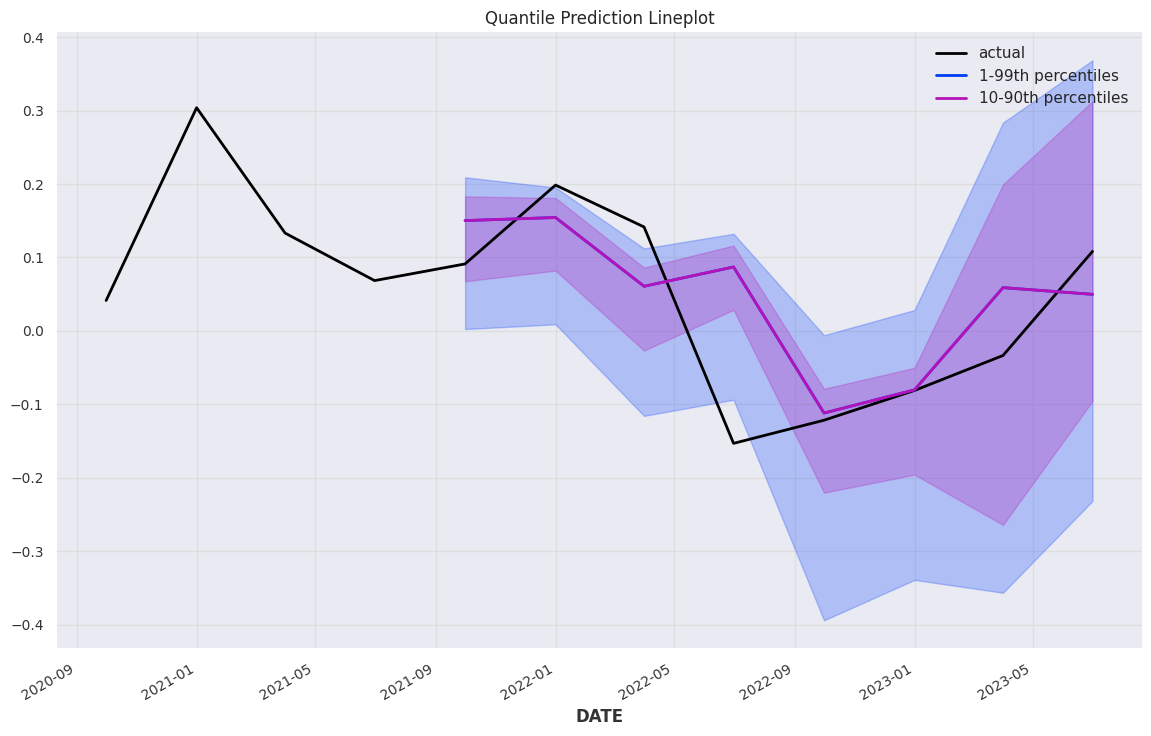

In [16]:
# Calculate the start time for the plot
plot_start_time = forecast.start_time() - (forecast.freq * (4))

# Slicing the actual series to the relevant range
series_transformed_sliced = st.slice(plot_start_time, forecast.end_time())

# plot actual series
plt.figure(figsize=figsize)
series_transformed_sliced.plot(label="actual")

# plot prediction with quantile ranges
forecast.plot(low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer)
forecast.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)

plt.title("Quantile Prediction Lineplot")
plt.legend()
plt.show()

In [17]:
print(f"MAE: {mae(eval, forecast):.4f}")
print(f"MAPE: {mape(eval, forecast):.4f} %")
print(f"MSE: {mse(eval, forecast):.4f}")
print(f"RMSE: {rmse(eval, forecast):.4f}")

MAE: 0.0732
MAPE: 79.9946 %
MSE: 0.0102
RMSE: 0.1011


## Save Predictions

In [18]:
main_prediction = forecast.quantile_timeseries(quantile=0.5)
df = main_prediction.pd_dataframe()
df=df.rename(columns={'WTI_0.5': 'WTI Q TFT'})
df.to_excel("WTI_Q_TFT_forecast.xlsx", index=True)
df

component,WTI Q TFT
DATE,
2021-10-01,0.150254
2022-01-01,0.154425
2022-04-01,0.060767
2022-07-01,0.087097
2022-10-01,-0.111894
2023-01-01,-0.080283
2023-04-01,0.058947
2023-07-01,0.049812


In [19]:
# Open a file in write mode
with open('WTI Q TFT Results.txt', 'w') as file:
    # Write the variables to the file
    file.write(f'{mae(eval, forecast):.4f}\n')
    file.write(f'{mape(eval, forecast):.4f}\n')
    file.write(f'{mse(eval, forecast):.4f}\n')
    file.write(f'{rmse(eval, forecast):.4f}\n')